In [1]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

sns.set_style("darkgrid")
plt.rcParams['figure.figsize']= 12,8

In [2]:
# importing the dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
# print the first 5 row of the train_df
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
# print the last 5 row of the test_df
test_df.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
362,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban
363,LP002975,Male,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban
364,LP002980,Male,No,0,Graduate,No,3250,1993,126.0,360.0,NaN,Semiurban
365,LP002986,Male,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural
366,LP002989,Male,No,0,Graduate,Yes,9200,0,98.0,180.0,1.0,Rural


In [5]:
# check the missing data
missing_value = train_df.isna().sum()
missing_value_per = train_df.isna().sum() / train_df.isna().count() * 100

Total_missing_values = pd.concat([missing_value, missing_value_per], axis=1, keys=["Missing_value", "%"])
Total_missing_values = Total_missing_values[Total_missing_values["%"]>0]
Total_missing_values

,Missing_value,%
Gender,13,2.117264
Married,3,0.488599
Dependents,15,2.442997
Self_Employed,32,5.211726
LoanAmount,22,3.583062
Loan_Amount_Term,14,2.280130
Credit_History,50,8.143322


# Feature Engineering
-Feature Engineering is the process of using domain knowledge to transform the faetures varible of the dataset when building a machine learning model inorder to increase the performace and the accuracy of the model 

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [7]:
# Endocing the Load_statue
mapping = {"Y":1, "N":0}
train_df["Loan_Status"] = train_df["Loan_Status"].map(mapping)

In [8]:
# splitting the features into independtent and dependent features
X= train_df.drop("Loan_ID", axis=1)
y = X.pop("Loan_Status")

In [9]:
# split the variable into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

#  Pipeline for data cleaning and transformation

In [10]:
numeric_feature = ["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term","Credit_History"]

category_feature = [ "Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"]

In [11]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())])

categorical_transformer= Pipeline(steps=[("imputer", SimpleImputer(strategy="constant")), ("encoder", OneHotEncoder())])

In [12]:
preprocessor = ColumnTransformer([("numeric", numeric_transformer, numeric_feature),
                                     ("category", categorical_transformer, category_feature),
                                    ])

In [13]:
classifier_names= ["svm", "adaboot", "decisontree", "logisticregression"]
classifiers = [SVC(), AdaBoostClassifier(), DecisionTreeClassifier(), LogisticRegressionCV()]


model_pipeline = [
    Pipeline([
        ("transformer", preprocessor),
        (classifier_name, classifier)
    ]) for classifier_name, classifier in zip(classifier_names, classifiers)
]

In [14]:

cv = KFold(5)
scoring = {"acc": "accuracy"}
training_scores = []
cv_scores = {classifier_name:[] for classifier_name in classifier_names}
for classifier_name, pipeline in zip(classifier_names, model_pipeline):
    cv_score = cross_validate(estimator=pipeline, X=x_train, y=y_train, cv=cv, scoring=scoring,
                             return_estimator=True, return_train_score=True)
    training_score=np.mean(cv_score["train_acc"]) * 100
    training_scores.append(training_score)
    cv_scores[classifier_name].append(cv_score)

In [15]:
best_estimators = {classifier_name:[] for classifier_name in classifier_names}

for key, model in cv_scores.items():
    best_test_score=np.argmax(model[0]["test_acc"])
    best_estimator=(model[0]["estimator"][best_test_score])        
    best_estimators[key].append(best_estimator)

In [16]:
test_scores, accuracys, precisions, recalls, f1 = [], [], [], [], []
for model in best_estimators.values():
    estimator=model[0].fit(x_train,y_train)
    y_pred =estimator.predict(x_test)
    test_score = estimator.score(x_test, y_test)
    test_scores.append(test_score)
    accuracys.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))    
    recalls.append(recall_score(y_test, y_pred))   
    f1.append(f1_score(y_test, y_pred))        

In [17]:
result_df = pd.DataFrame({
    "model": classifier_names,
    "train_score": np.array(training_scores),
    "test_score": np.array(test_scores) * 100,
    "precision_score": np.array(precisions) * 100,
    "accuracys_score": np.array(accuracys) * 100,
    "recalls_score": np.array(recalls) * 100,
})

In [19]:
result_df

,model,train_score,test_score,precision_score,accuracys_score,recalls_score
0,svm,81.771434,82.926829,82.242991,82.926829,97.777778
1,adaboot,84.775536,83.739837,84.313725,83.739837,95.555556
2,decisontree,100.000000,67.479675,82.894737,67.479675,70.000000
3,logisticregression,80.600431,83.739837,83.018868,83.739837,97.777778


<AxesSubplot:xlabel='test_score', ylabel='model'>

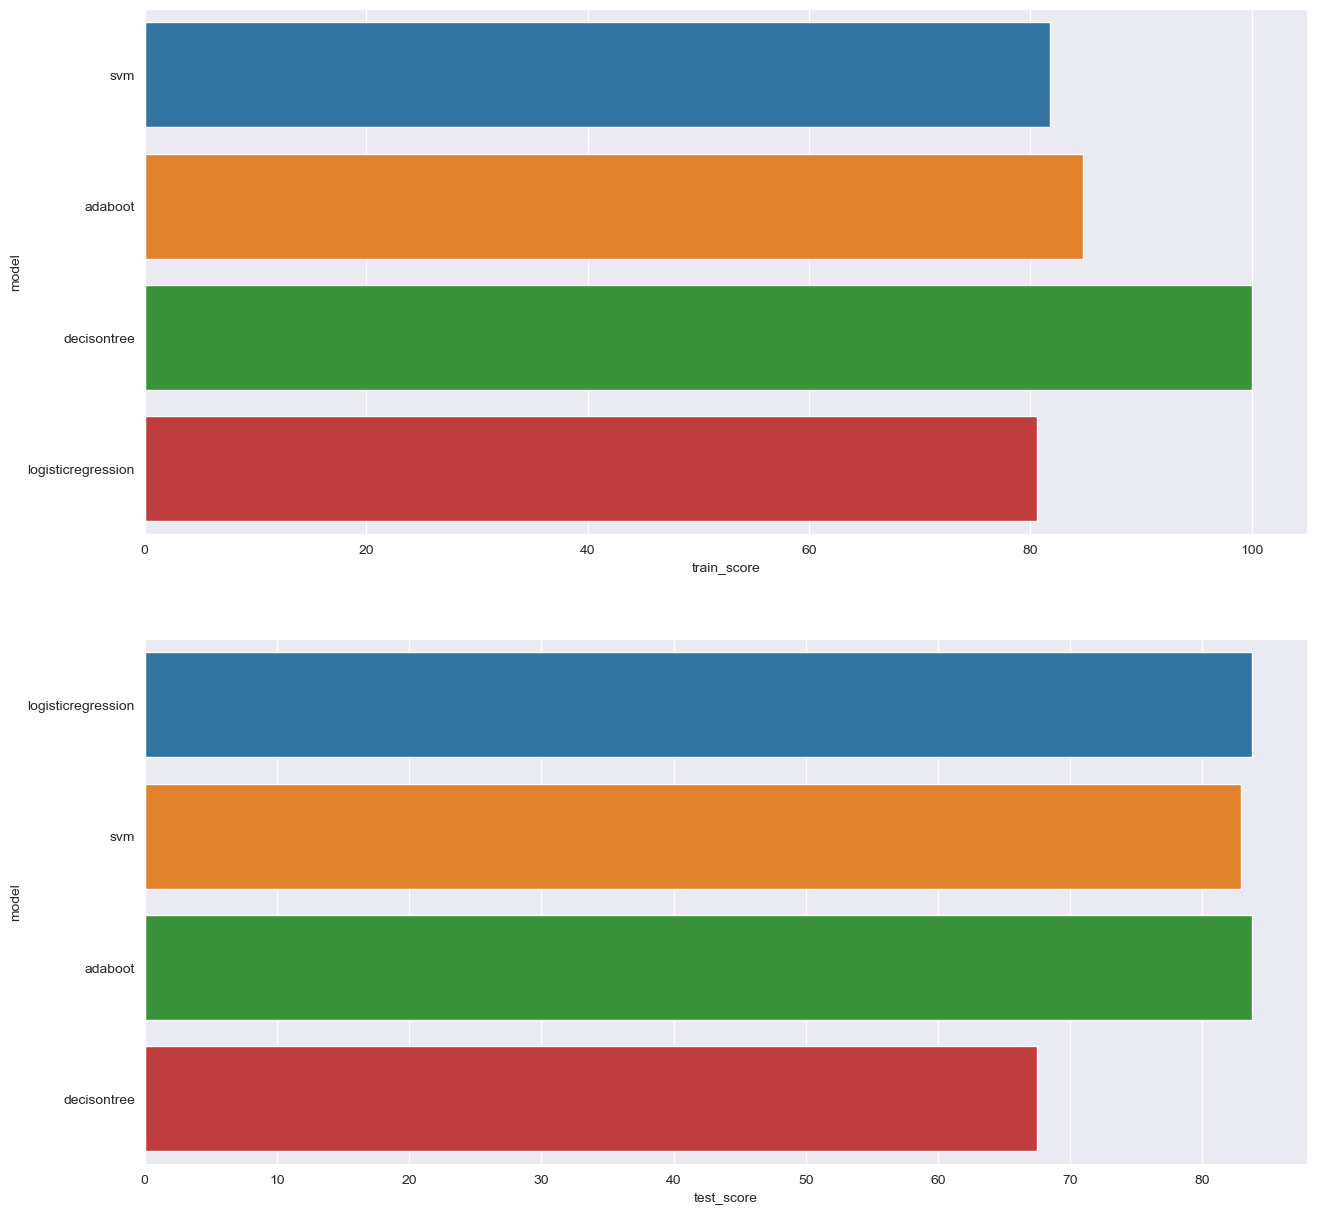

In [24]:
fig, ax = plt.subplots(figsize=(15, 15), ncols=1, nrows=2)
sns.barplot(data=result_df, y="model", x="train_score", ax=ax[0])
sns.barplot(data=result_df, y="model", x="test_score", ax=ax[1],
            order=result_df.sort_values("train_score", ascending=True).model)

In [18]:
 modl =  best_estimators['logisticregression'][0]

In [30]:
# Add Logistic Regression with GridSearchCV
logistic_pipeline = Pipeline([
    ("transformer", preprocessor),
    ("logisticregression", LogisticRegressionCV(max_iter=1000))
])

# Define hyperparameter grid for Logistic Regression
param_grid = {
    'logisticregression__Cs': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__cv': [3, 5, 7],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'lbfgs']
}

# Create GridSearchCV instance
grid_search = GridSearchCV(logistic_pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_logistic_model = grid_search.best_estimator_

# Now best_logistic_model is the fine-tuned Logistic Regression model


C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
225 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Trac

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Credit_History']),
                                                 ('category',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy=

In [32]:
best_params

{'logisticregression__Cs': 10,
 'logisticregression__cv': 3,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

In [34]:
# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [35]:
# Set the best hyperparameters in the model
best_model.set_params(**best_params)


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Credit_History']),
                                                 ('category',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy=

In [38]:
# Retrain the model on the entire training dataset
j=best_model.fit(x_train, y_train)

In [39]:
j.score(x_test, y_test)

0.8373983739837398